<img src="./pictures/logo-insa.png" style="float:right; max-width: 60px; display: inline" alt="INSA" /></a>

# Sizing code of an inductor with surrogate models
*Written by Marc Budinger, INSA Toulouse, France*

The previous study showed some shortcomings such as not taking into account the thermal and a limitation on the dimensions of the air gap. We will see here how to set up surrogate models from thermal or magnetic finite element simulations.  
  

## Thermal configuration description

In the previous notebook, the current density $J$ was imposed. It would be more accurate to calculate the temperature of the hot point of the winding and adjust the value of this current density to limit, for example at 150 ° C, this temperature. The cooling architecture of the various components of the converter takes the following form in this study:

![ArchiThermic](pictures/ThermalArchitecture.png)

In order to carry out finite element simulations in 2D, we will work on a P-type core which presents a symmetry of revolution.

![PotCore](pictures/PotCore.png)

Other forms of ferrite cores can be found [here](https://www.ferroxcube.com).

We will assume here to calculate the temperature of the hot spot of the winding:
- that temparature of the pot base is fixed
- that the convective heat transfer is negligible
- that the winding can be represented by an equivalent thermal conductivity

![HotSpotInducteurFEM](pictures/HotSpotInducteurFEM.png)

The following table shows some simulation results for different materials configurations and the same level of loss (36W into the coil, 100 mm for the external diameter of the core, 1 mm of airgap). These simulations show that the heat transfer can be optimized in a technological way. We will use  the configuration (3), the most effective, for next calculations.

|   Central Axis     | Airgap  | Hot spot Temperature |
| -------------- | --------------| -----------|
| Air | Air       | 122 °C            |
| Air | Resin   | 90 °C |
| Aluminum   | Resin  | 61 °C | 



## Buckingham theorem and dimensional analysis 

FEM simulations can take computational time not compatible with design optimization and design space exploration. One way of reducing this computational time is by constructing approximation models, known as [surrogate models](https://en.wikipedia.org/wiki/Surrogate_model), response surface models or metamodels.  
In order to reduce the number of variables to manipulate during analysises, dimensional analysis and the [Buckingham theorem](https://en.wikipedia.org/wiki/Buckingham_%CF%80_theorem) can be used. 

We want to find a surrogate model which enable to caculate the thermal resistance between the hot spot of the coil and the support of the core:  
$R_{th}=f(D,e,...,\lambda_{eq},\lambda_{ferrite},...)$
with:  
- $D,e,...$ : the diameter of the pot core, the airgap thickness, other geometrical dimensions. Ferrites cores follow geometrical similarities except for the airgap.
- $\lambda_{eq},\lambda_{ferrite},...$ : the equivalent thermal conductivity of the coil and the other thermal conductivities.

> Exercice 1: reduce the number of variables to manipulate with the Buckingham theorem. Give expression of $\pi_i$ numbers.



> Exercice 2: Justify your dimensional analysis with the following FEMM results.

|        | Diameter $D$  | Copper losses | Airgap $e$ | Eequivalent thermal conductivity (coil)| Temperature difference $\Delta \Teta$  | 
| -------------- | --------------| -----------| -----------| -----------| -----------|
| 1 | 100 mm       | 36 W            | 1 mm | 0.5 W/(mK) | 61 °C |
| 2 | 50 mm   | 4.5 W | 0.5 mm | 0.5 W/(mK) | 15.3 °C |
| 3  | 50 mm  | 4.5 W | 0.5 mm | 1 W/(mK) | 12.9 °C |



## Surface response model for the thermal resistance

Multiple FEM simulations have been performed. The following file summurizes usefull data:

In [1]:
# Import FEM thermal simulations results

# Panda package Importation
import pandas as pd

# Read the .csv file with bearing data
path='./'
dRth = pd.read_csv(path+'InductorThermalSurrogate.csv', sep=';')

# Print the head (first lines of the file)
dRth.head()

,D,Lambda,P,T,DT,Rth,PI0=Rth.Lambda.D,PI1=e/D
0,0.1,0.5,35.852,356.15,56.15,1.566161,0.078308,0.001000
1,0.1,0.5,35.884,356.55,56.55,1.575911,0.078796,0.001585
2,0.1,0.5,35.935,357.16,57.16,1.590650,0.079532,0.002512
3,0.1,0.5,36.016,358.06,58.06,1.612061,0.080603,0.003981
4,0.1,0.5,36.143,359.38,59.38,1.642918,0.082146,0.006310


We want to perform here a linear regression to determine an estimation model of polynomial form.  

> Exercice: Perform this multiple linear regression with the [StatsModels](https://www.statsmodels.org/stable/index.html) package and dedicated transformations.


In [9]:
# Determination of the least squares estimator with the OLS function 
# of the SatsModels package

import numpy as np
import statsmodels.api as sm

# Generation of Y and X matrix
Y=dRth['PI0=Rth.Lambda.D'].values
Y=Y.reshape((np.size(Y),1))
X=np.transpose(np.array((np.ones(np.size(dRth['PI1=e/D'].values)), dRth['PI1=e/D'].values, (dRth['PI1=e/D'].values)**2)))

# OLS regression
modelRth = sm.OLS(Y, X)
resultRth = modelRth.fit()

# Results print
print('Parameters: ', resultRth.params)
print('R²: %.3f'% resultRth.rsquared)

print('The estimation function is: PI0 = %.3g + %.3g PI1 + %.3g PI1^2'
      %(resultRth.params[0],resultRth.params[1],resultRth.params[2]))


Parameters:  [ 0.0785531   0.52392117 -2.04263184]
R²: 0.997
The estimation function is: PI0 = 0.0786 + 0.524 PI1 + -2.04 PI1^2


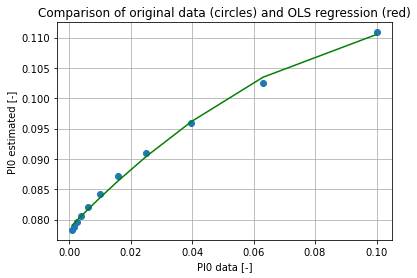

In [8]:
import matplotlib.pyplot as plt

# Y vector prediction
y_OLS=resultRth.predict(X)

# plot the data 
plt.plot(dRth['PI1=e/D'].values,dRth['PI0=Rth.Lambda.D'].values, 'o',dRth['PI1=e/D'].values,y_OLS, '-g')
plt.xlabel('PI0 data [-]')
plt.ylabel('PI0 estimated [-]')
plt.title('Comparison of original data (circles) and OLS regression (red)')
plt.grid()
plt.show()

## Surrogate magnetic model for inductance
The same approcach can be adopted for magnetic simulations. The model has to take in account the magnetic field in the airgap for small and big values, and using finite elements simulations the proportion of the magnetic field outside the magnetic circuit is also considered. These effects are not well modelled by classical analytic models.  
The inductance is represented by the reluctance of the magnetic circuit $R_L$: $L=n^2/R_L$, where $L$ is the inductance, $n$ the number of turns.  
Two assumptions are considered for the study:
- The reluctance of the ferrite magnetic circuit is considered during the FEM simulation but neglected for the final expression.
- The saturation effects are not considered.

Regression on FEM simulation data with log transformation give the following expression:  
$\pi_0=R_Lμ_0D=3.86π_1^{0.344-0.226 log⁡(π_1)-0.0355 log⁡(π_1)}$   
or  
$R_L=\frac{3.86}{μ_0D}π_1^{0.344-0.226 log⁡(π_1)-0.0355 log⁡(π_1)}$    
,where $π_1=e/D$.  

> Remark: the reluctance and current density can be used in order to calculate the magnetic energy   
> $E_m=\frac{1}{2}LI^2=\frac{1}{2}\frac{n^2}{R_L} (\frac{JS_{copper}}{n})^2=1/R_L (JS_{copper})^2$    

## Inductor sizing code

> Exercice: adapt the sizing code of the previous notebook in order to take into account the 2 surrogate models.

In [10]:
%%writefile sizing_inductor.py

import numpy as np
import scipy
import scipy.optimize
from math import pi, sqrt
import timeit

# Specifications
IL_max=150 # [A] max current
IL_RMS=140 # [A] RMS current
L=150e-6 # [H] Inductance
 
# Assumptions
#J=5e6 # [A/m²] Current density
B_mag=0.4 # [T] Induction
k_bob=0.33 # [-] winding coefficient
T_amb=60 # [°C] Support temperature
T_max=150 # [°C] Max temperature

# Physical constants
mu_0=4*3.14e-7 # [SI] permeability

# Reference parameters for scaling laws (Pot core)

D_ref=66.29e-3 # [m] External diameter
H_ref=57.3e-3/2 # [m] 1 half core height

Airon_ref=pi/4*(29.19**2-6.5**2)*1e-6    # [m^2] iron surface
Awind_ref=43.28*(54.51-28.19)/2*1e-6    # [m^2] winding surface
Rmoy_ref=(54.51-28.19)/2*1e-3 # [m] Mean radius for winding

M_ref=225e-3  # [kg] 1 half core mass


# -----------------------
# sizing code
# -----------------------
# inputs: 
# - param: optimisation variables vector 
# - arg: selection of output  
# output: 
# - objective if arg='Obj', problem characteristics if arg='Prt', constraints other else

def SizingInductor(param, arg):
    # Variables
    e_D=param[0] # [m] air gap / External diameter
    J=param[1]*1e6 # [A/m²] current density
    
    # Magnetic pi_0
    PI0_m=3.86*e_D**(0.344-0.226*np.log10(e_D)-0.0355*(np.log10(e_D))**2)
    
    # Magnetic energy calculation
    E_mag=1/2*L*IL_max**2 # [J] Energy
    
    D=(E_mag*2*PI0_m*D_ref**4/J**2/k_bob**2/Awind_ref**2/mu_0)**(1/5) # External diameter calculation
          
    # Reluctance and inductance
    RL=PI0_m/mu_0/D  # [] reluctance
    N=np.sqrt(L*RL) # [-] turn number
    
    # Wire section & winding surface
    S_w=IL_RMS/J # [m²] 1 wire section area
    S_bob=N*S_w/k_bob # [m^2] winding surface
  
    # Core scaling
    A_iron=Airon_ref*(D/D_ref)**(2) # [m^2] iron surface
    A_wind=Awind_ref*(D/D_ref)**(2) # [m^2] winding surface
    H=H_ref*(D/D_ref)**(1) # [m] 1 half core height    
    Rmoy=Rmoy_ref*(D/D_ref)**(1) # [m] Mean radius for winding
    
    M_core =M_ref*(D/D_ref)**(3) # [kg] one half core mass

    # Magnetic field
    B=N*IL_max/RL/A_iron # [T]
    
    # Mass
    M_copper=2*pi*Rmoy*N*S_w*7800
    M_total=M_copper+M_core*2
    
    # Temperature calculation
    PI0_t = 0.0786 + 0.524*e_D -2.04*e_D**2 # PI0 thermal
    Rth=PI0_t/(0.5*D) # [K/W] thermal resistance
    
    PJ=J**2*2*pi*Rmoy*N*S_w*1.7e-8 # [W] Joules losses
    
    Teta_hot=T_amb + PJ*Rth # [°C] Hot spot temperature
    
    # Objective and contraints
    if arg=='Obj':
        return M_total
    elif arg=='Prt':
        print("* Optimisation variables:")
        print("           Airgap e/D = %.2g"% (e_D))
        print("           Current dendity J = %.2g"% (J))
        print("* Components characteristics:")
        print("           Core (2) mass = %.2f kg" % (2*M_core))
        print("           Coil mass = %.2f kg" % M_copper)
        print("           Core dimensions = %.1f (diameter) x %.1f (heigth) mm"%((D*1e3,2*H*1e3)))
        print("           Airgap e = %.1f mm"%(e_D*D*1e3))
        print("           A_iron = %.0f mm^2"%(A_iron*1e6))
        print("           Number of turns = %i"%(N))
        print("* Constraints (should be >0):")
        print("           Winding  surface margin = %.3f mm²" % ((A_wind-S_bob)*1e6))
        print("           Induction margin = %.3f T" %((B_mag-B)))
        print("           Temperature margin = %.3f K" %(T_max-Teta_hot))
    else:
        return [A_wind-S_bob, B_mag-B, T_max-Teta_hot]

Overwriting sizing_inductor.py


In [12]:
%run sizing_inductor.py

#Variables d'optimisation
e_D=1e-3 # [m] airgap
J=50 # [A/mm²] current density


# Vector of parameters

parameters = np.array((e_D,J))

# Initial characteristics before optimization 
print("-----------------------------------------------")
print("Initial characteristics before optimization :")

SizingInductor(parameters, 'Prt')
print("-----------------------------------------------")

# optimization with SLSQP algorithm
contrainte=lambda x: SizingInductor(x, 'Const')
objectif=lambda x: SizingInductor(x, 'Obj')
result = scipy.optimize.fmin_slsqp(func=objectif, x0=parameters, 
                                   bounds=[(1e-3,1e-1),(1,50)],
                                   f_ieqcons=contrainte, iter=100, acc=1e-12)

# Final characteristics after optimization 
print("-----------------------------------------------")
print("Final characteristics after optimization :")

SizingInductor(result, 'Prt')
print("-----------------------------------------------")


-----------------------------------------------
Initial characteristics before optimization :
* Optimisation variables:
           Airgap e/D = 0.001
           Current dendity J = 5e+07
* Components characteristics:
           Core (2) mass = 0.03 kg
           Coil mass = 0.01 kg
           Core dimensions = 28.2 (diameter) x 24.3 (heigth) mm
           Airgap e = 0.0 mm
           A_iron = 115 mm^2
           Number of turns = 11
* Constraints (should be >0):
           Winding  surface margin = 6.852 mm²
           Induction margin = -16.941 T
           Temperature margin = -175.549 K
-----------------------------------------------
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3.605397381031394
            Iterations: 16
            Function evaluations: 37
            Gradient evaluations: 12
-----------------------------------------------
Final characteristics after optimization :
* Optimisation variables:
           Airgap e/D = 0.049

## Annex : thermal conductivity 

|   Material    | Thermal conductivity |
| -------------- | --------------|
| Copper | 400 W/(mK)            |
| Aluminum  | 200 W/(mK) |
| Air   | 0.03 W/(mK) | 
| Ferrite   | 5 W/(mK) | 
| Resin   | 0.25 W/(mK) |
| Copper+Resin(*)   | 0.5 W/(mK) | 

(*) for a mix of 33% copper, 66% resin
